In [1]:
import pandas as pd
import arviz as az 
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
reedfrogs = pd.read_csv('./data/reedfrogs.csv')

In [3]:
reedfrogs.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [4]:
with pm.Model() as m1:
    alpha_tank = pm.Normal('alpha_tank', 0, 1.5, shape=len(reedfrogs))
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank))
    surivals = pm.Binomial('survivals',  p=p, n=reedfrogs.density,observed=reedfrogs.surv)

In [5]:
with m1:
    posterior_m1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [6]:
with pm.Model() as m2:
    sigma = pm.Exponential('sigma', 1)
    alpha_hat = pm.Normal('alpha_hat', 0, 1.5)
    alpha_tank = pm.Normal('alpha_tank', alpha_hat, sigma, shape=len(reedfrogs))
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank))
    surivals = pm.Binomial('survivals', reedfrogs.density, p, observed=reedfrogs.surv)

In [7]:
with m2:
    posterior_m2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, alpha_tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [8]:
az.waic(posterior_m1)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -106.76     2.26
p_waic       25.02        -

There has been a warning during the calculation. Please check the results.

In [9]:
az.waic(posterior_m2)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -99.98     3.63
p_waic       20.89        -

There has been a warning during the calculation. Please check the results.

In [10]:
with m2:
    pp_m2 = pm.sample_posterior_predictive(posterior_m2)

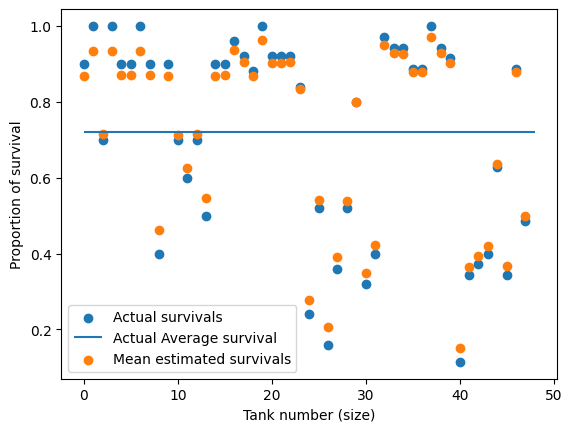

In [11]:
plt.scatter(reedfrogs.index, reedfrogs.propsurv, label='Actual survivals')
plt.hlines(np.mean(reedfrogs.propsurv), 0, 48, label='Actual Average survival')
plt.scatter(reedfrogs.index, pp_m2.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density, label='Mean estimated survivals')
plt.ylabel('Proportion of survival')
plt.xlabel('Tank number (size)')
plt.legend()

Ok so we see the effect that the partial pooling model shrinks the posterior to the mean tank. Moreover, smaller tanks shrink more than bigger tanks. And the farther from the mean the stronger the shrinkage.

<AxesSubplot:>

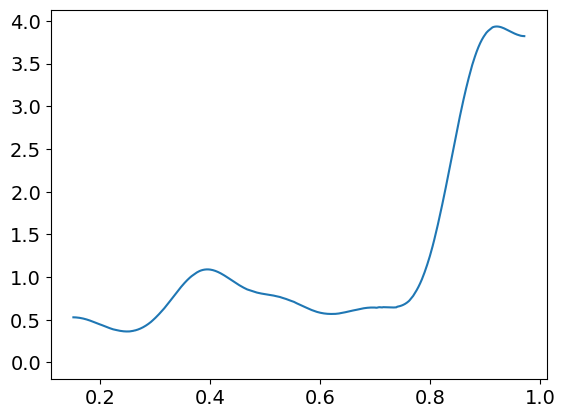

In [20]:
az.plot_dist(posterior_m2.posterior.mean(["chain", "draw"])['p'])

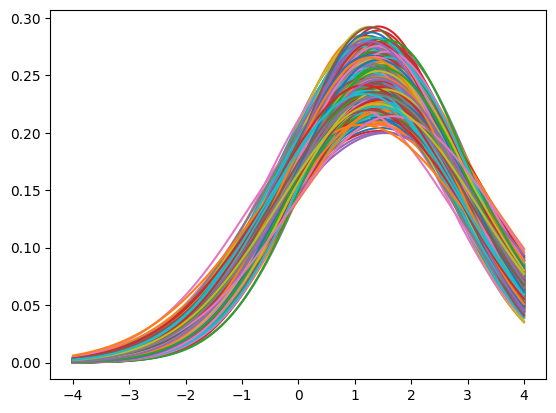

In [30]:

import scipy.stats as stats
alpha_hat = posterior_m2.posterior.mean(["chain"])['alpha_hat']
sigma = posterior_m2.posterior.mean(["chain"])['sigma']


x=np.linspace(-4,4, 1000)
for i in range(0, 1000):
    plt.plot(x, stats.norm.pdf(x, alpha_hat[i], sigma[i]))


13.2 Varying effects and the underfitting/overfitting tradeoff.

We'll run a simulation on fake data so that we can understand the effect of complete/partial/no pooling.
For that we need alpha_hat, sigma, alphas and sample sizes per pond

In [95]:
a_bar = 1.5
sigma = 1.5
ponds = 60
sizes = np.array([5]*15+[10]*15+[25]*15+[35]*15)

In [96]:
alphas = np.random.normal(loc=a_bar, scale=sigma, size=ponds)

In [97]:
def inv_logit(a):
    return np.exp(a) / (1+np.exp(a))
real_p = inv_logit(alphas)


In [98]:
survivors=[np.random.binomial(p=real_p[i], n=sizes[i]) for i in range(0, len(sizes))]

In [99]:
no_pooling_estimates = survivors / sizes

In [100]:
with pm.Model() as m3:
    sigma = pm.Exponential('sigma', 1)
    alpha_hat = pm.Normal('alpha_hat', 0, 1.5)
    alpha_pond = pm.Normal('alpha_tank', alpha_hat, sigma, shape=ponds)
    p = pm.Deterministic('p', pm.math.invlogit(alpha_pond))
    surivals = pm.Binomial('survivals', sizes, p, observed=survivors)

In [101]:
with m3:
    m3_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, alpha_tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [102]:
with m3:
    m3_posterior_predictive = pm.sample_posterior_predictive(m3_posterior)

In [103]:
no_pool_abs_error = np.abs(real_p-no_pooling_estimates)
partial_pool_abs_error = np.abs(real_p-m3_posterior.posterior.mean(["chain", "draw"])['p'].to_numpy())



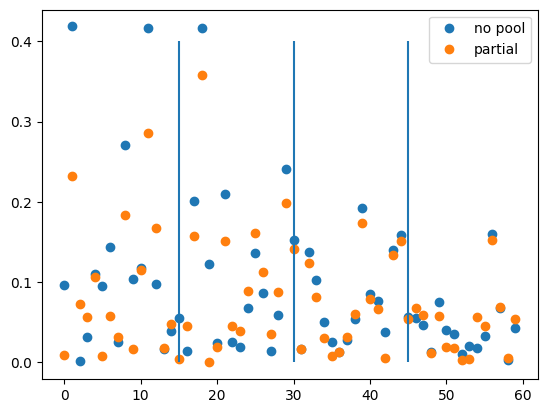

In [115]:
ponds_list = list(range(0, ponds))
plt.plot(ponds_list, no_pool_abs_error, 'o', label='no pool')
plt.plot(ponds_list, partial_pool_abs_error, 'o', label='partial')
for index in [15, 30,45]:
    plt.vlines(ymin=0, ymax=0.4, x=index)
plt.legend()

# 13.3 More than one type of cluster

In [118]:
chimps = pd.read_csv("./data/chimpanzees.csv", sep=';')

In [120]:
chimps.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [121]:
chimps['treatment'] = chimps.prosoc_left + 2 * chimps.condition

In [135]:

with pm.Model() as m4:
    actor = np.array(chimps.actor) -1 
    block = np.array(chimps.block) - 1
    treatment = np.array(chimps.treatment)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    alpha_hat = pm.Normal("alpha_hat", 0, 1.5)
    gamma_block = pm.Normal("gamma_block", 0, sigma_gamma, shape=6)
    alpha_actor = pm.Normal("alpha_actor", alpha_hat, sigma_alpha, shape=7)
    beta_treatment = pm.Normal("beta_treatment", 0, 0.5, shape=4)
    p = pm.Deterministic("p", pm.math.invlogit(alpha_actor[actor]  + gamma_block[block] + beta_treatment[treatment]))
    l = pm.Binomial("l", n=1, p=p)

In [136]:
with m4:
    m4_posterior = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma_gamma, sigma_alpha, alpha_hat, gamma_block, alpha_actor, beta_treatment]
>Metropolis: [l]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.
There were 838 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.003331, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6941, but should be close to 0.8. Try to increase the number of tuning steps.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6945, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invali

In [137]:
# Example of divergences

In [138]:
with pm.Model() as m5:
    v = pm.Normal('v', 0, 3)
    x = pm.Normal('x', 0, pm.math.exp(v))

In [139]:
with m5:
    posterior_m5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.414, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7111, but should be close to 0.8. Try to increase the number of tuning steps.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4517, but should be close to 0.8. Try to increase the number of tuning steps.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.


In [140]:
with pm.Model() as m6:
    v = pm.Normal('v', 0, 3)
    z = pm.Normal('z', 0, 1)
    x = pm.Deterministic('x', z * pm.math.exp(v))

In [141]:
with m6:
    posterior_m6 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [142]:
# Decentering the chimps model

In [144]:

with pm.Model() as m4_bis:
    actor = np.array(chimps.actor) -1 
    block = np.array(chimps.block) - 1
    treatment = np.array(chimps.treatment)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    alpha_hat = pm.Normal("alpha_hat", 0, 1.5)
    
    z_block = pm.Normal('z_block', 0,1, shape=6)
    z_actor = pm.Normal('z_actor', 0,1, shape=7)
    gamma_block = pm.Deterministic("gamma_block", z_block * sigma_gamma)
    alpha_actor = pm.Deterministic("alpha_actor", alpha_hat + z_actor * sigma_alpha)
    
    beta_treatment = pm.Normal("beta_treatment", 0, 0.5, shape=4)
    p = pm.Deterministic("p", pm.math.invlogit(alpha_actor[actor]  + gamma_block[block] + beta_treatment[treatment]))
    l = pm.Binomial("l", n=1, p=p)

In [145]:
with m4_bis:
    m4_bis_posterior = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma_gamma, sigma_alpha, alpha_hat, z_block, z_actor, beta_treatment]
>Metropolis: [l]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
